In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.ensemble
import torch

Fetch the data frames from the files

In [ ]:
# read both the matches and the frames
training_df = pd.read_csv('../data/processed/diff_train.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
test_df = pd.read_csv('../data/processed/diff_test.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
training_df = training_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})
test_df = test_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})



Helper functions to format the data prior to training

In [51]:

def plot_data(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==-1].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')  

def plot_rf_prediction(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    Assumes at most 3 classes.
    """
    extent = (0, 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')

def scale_data(X_trn, X_tst):
    # Scale the data with MinMax to avoid negative values
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst

def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need
    plt.figure()
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)
    

def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    estimators = [0 for i in range(len(param_vals))]
    for x in range(len(param_vals)):
        estimators[x] = estimator_type(**{param_name: param_vals[x]}, **kwargs).fit(X, y)
        # Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
        print("Training " + estimator_type.__name__ + "(" + param_name + "=%d " % param_vals[x] + " {0}={1} ".format(
            kwargs.keys(), kwargs.values()))
    return estimators


Feature selection: Select an X and y we want to train on

In [ ]:
X_trn = training_df[['kill_advantage','gold_advantage']].values
y_trn = training_df[['winner']].values.T[0]
X_tst = test_df[['kill_advantage','gold_advantage']].values
y_tst = test_df[['winner']].values.T[0]



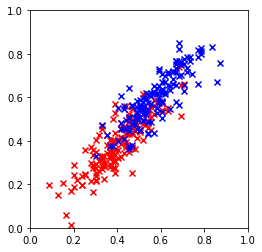

In [48]:
plot_data(X_trn[:300], y_trn[:300])

## Dummy Classifier

In [ ]:

## Here we train a dummy classifier to compare performance
def train_dummy_classifier(X, y):
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    # Scale the data with MinMax to avoid negative values
    dummy_clf.fit(X, y)
    return dummy_clf


## kNN 

In [ ]:
def train_kNN_estimators(X_trn,X_tst,y_trn,y_tst):
    param_vals = [1, 5, 10, 15, 20]
    # for x in range(5):
    #     estimators[x] = sklearn.neighbors.KNeighborsClassifier(n_neighbors=param_vals[x]).fit(X_trn, y_trn)
    # trn_scores = score_estimators(X_trn, y_trn, estimators)
    # tst_scores = score_estimators(X_tst, y_tst, estimators)
    # X_axis = np.arange(0, 5)
    # plt.title(estimators[0].__class__.__name__ + " score vs " + "n_neighbors")
    # plt.xlabel("n_neighbors")
    # plt.ylabel("score")
    # plt.ylim(0.0, 1.05)
    # plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    # plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    # plt.legend()
    # plt.xticks(X_axis, param_vals)

    knn_estimators = train_estimators(X_trn, y_trn, sklearn.neighbors.KNeighborsClassifier, 'n_neighbors',
                                      param_vals=param_vals)

    plot_estimator_scores(knn_estimators, param_name='n_neighbors', param_vals=param_vals)


## Random Forests

In [61]:
def train_random_forests(X_trn, X_tst, y_trn, y_tst):
    estimator = np.arange(1, 3) * 50
    depths = np.arange(1, 3) * 5
    estimators_meshed, depths_meshed = np.meshgrid(estimator, depths)

    trn_scores = np.arange(0, 25, dtype=float)
    tst_scores = np.arange(0, 25, dtype=float)
    X_axis = np.arange(0, 25)
    para_vals = np.array(
        ["50:5", "50:10", "50:15", "50:20", "50:25", "100:5", "100:10", "100:15", "100:20", "100:25", "150:5", "150:10",
         "150:15", "150:20","150:25","200:5", "200:10", "200:15", "200:20", "200:25", "250:5", "250:10", "250:15",
         "250:20", "250:25"])
    print(X_axis.shape)
    print(para_vals.shape)
    param_grid = {
        'n_estimators': estimator, 
        'max_depth': depths
    }
    clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
    gscv = sklearn.model_selection.GridSearchCV(clf, param_grid=param_grid, verbose=1, cv=3)
    gscv.fit(X_trn, y_trn)
    # for i in range(5):
    #     for j in range(5):
    #         random_forest_model = sklearn.ensemble.RandomForestClassifier(n_estimators=estimators_meshed[j][i],
    #                                                                       max_depth=depths_meshed[j][i],
    #                                                                       random_state=0).fit(X_trn, y_trn)
    #         trn_scores[i * 5 + j] = sklearn.metrics.accuracy_score(y_trn, random_forest_model.predict(X_trn))
    #         print("Training Accuracy: %.2f %% with estimators = %d , depth = %d \n" % (
    #             trn_scores[i * 5 + j] * 100, estimators_meshed[j][i], depths_meshed[j][i]))
    #         tst_scores[i * 5 + j] = sklearn.metrics.accuracy_score(y_tst, random_forest_model.predict(X_tst))
    #         print("Test Accuracy: %.2f %% with estimators = %d , depth = %d \n" % (
    #             tst_scores[i * 5 + j] * 100, estimators_meshed[j][i], depths_meshed[j][i]))
    #         print("Pr/Rec/Fscore: ")
    #         print(sklearn.metrics.precision_recall_fscore_support(y_tst, random_forest_model.predict(X_tst), average='binary'))
    plt.figure()
    plot_data(X_trn, y_trn)
    plot_rf_prediction(gscv.best_estimator_)
    return gscv.best_estimator_
    # plt.title("Random Forests score vs estimators : depth")
    # plt.xlabel("estimators : depth")
    # plt.ylabel("score")
    # plt.ylim(0.0, 1.05)
    # plt.plot(X_axis, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    # plt.plot(X_axis, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    # plt.legend()
    # print(para_vals)
    # plt.xticks(X_axis, para_vals, fontsize=5)


## Neural Network

In [ ]:
## This is the neural network trained in Lab 8

def train_neural_network(X_trn, X_tst, y_trn, y_tst):
    # Tensors setup
    X_trn_torch = torch.tensor(X_trn, dtype=torch.float32)
    y_trn_torch = torch.tensor(y_trn, dtype=torch.int64)
    X_tst_torch = torch.tensor(X_tst, dtype=torch.float32)
    y_tst_torch = torch.tensor(y_tst, dtype=torch.int64)

    torch.manual_seed(0) # Ensure model weights initialized with same random numbers

    # Create an object that holds a sequence of layers and activation functions
    model = torch.nn.Sequential(
        torch.nn.Linear(20, 10),   # Applies Wx+b from 10 dimensions down to 2
        torch.nn.ReLU(),
        torch.nn.Linear(10,2)
    )

    # Create an object that can compute "negative log likelihood of a softmax"
    loss = torch.nn.CrossEntropyLoss()

    # Use stochastic gradient descent to train the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    # Use 100 training samples at a time to compute the gradient.
    batch_size = 200

    # Make 10 passes over the training data, each time using batch_size samples to compute gradient
    num_epoch = 10
    next_epoch = 1

    for epoch in range(next_epoch, next_epoch+num_epoch):
        # Make an entire pass (an 'epoch') over the training data in batch_size chunks
        for i in range(0, len(X_trn), batch_size):        
            X_cur = X_trn_torch[i:i+batch_size]     # Slice out a mini-batch of features
            y_cur = y_trn_torch[i:i+batch_size]     # Slice out a mini-batch of targets
            
            y_pred = model(X_cur)                   # Make predictions (final-layer activations)
            l = loss(y_pred, y_cur)                 # Compute loss with respect to predictions
            
            model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
            l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
            optimizer.step()                    # Use the gradients to take a step with SGD.
            
        print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
        
    print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
    next_epoch = epoch+1


## Evaluation

(25,)
(25,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


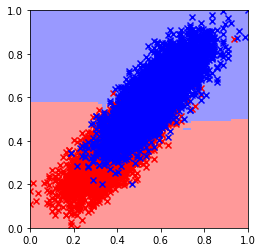

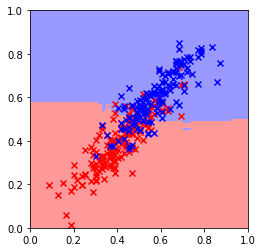

In [62]:

X_trn, X_tst = scale_data(X_trn, X_tst)
# train_neural_network(X, y)
# train_kNN_estimators(X_trn, X_tst, y_trn, y_tst)
rf_clf = train_random_forests(X_trn, X_tst, y_trn, y_tst)

dm_clf = train_dummy_classifier(X_trn, y_trn)
y_pred = dm_clf.predict(X_tst)
stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
sklearn.metrics.accuracy_score(y_tst, y_pred)
plt.figure()
plot_data(X_trn[:300], y_trn[:300])
plot_rf_prediction(rf_clf)